# Random Forest Modeling 

Before Describing the Random Forest, lets look at what the forest is compromised of: decision trees. Decision trees takes a dataset consisting of X and y data, finds rules based on our X data that (splits) our data into smaller datasets such that by the bottom of the tree, the values y in each "leaf node" are as "pure" as possible (i.e. the tree cannot form anymore roots because there are no more decisions to be made). This is very similar to the game of 20 question: start with a general question and progressively refine until the finding answer. 

We then create an ensemble of decision trees utilizing the bootstrap methodology. Our goal is to estimate the true function by aggregating decision trees together so that the model is not overfit. We can come up with different models  by training decision trees with different portions of the training data, aggregating all tree results and so on to get as close to the true function as possible. 

A Random forest is a modified tree tree learning algorithm similar to bootstrapping that selects, at each split in the learning process, a random subset of the features. This process is sometimes called the random subspace method.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from sklearn import metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [3]:
# Reading in the DataFrame
df = pd.read_csv('../Data/casual_political.csv')

In [95]:
# Checking the head of the DataFrame to ensure everything is the same as LogReg
df.head()

,binary_sub,NN,NNP,VBG,PRP,VBP,TO,VB,IN,CC,...,DT,RB,RBR,PRP$,VBN,vader_negative,vader_positive,vader_neutral,vader_compound,lemma_totaltext
0,1,0.172185,0.059603,0.033113,0.046358,0.052980,0.033113,0.066225,0.145695,0.039735,...,0.125828,0.039735,0.000000,0.000000,0.019868,0.070,0.127,0.802,0.9173,Could the Senate move for a motion of no confi...
1,1,0.107143,0.023810,0.000000,0.047619,0.047619,0.011905,0.059524,0.095238,0.047619,...,0.095238,0.071429,0.000000,0.000000,0.083333,0.206,0.073,0.721,-0.8732,Should verbal error by presidential candidate ...
2,0,0.131429,0.000000,0.034286,0.154286,0.057143,0.017143,0.034286,0.148571,0.051429,...,0.062857,0.051429,0.011429,0.028571,0.034286,0.141,0.083,0.777,-0.8438,I finally get bang today after a year of go ba...
3,0,0.202020,0.060606,0.030303,0.090909,0.020202,0.010101,0.030303,0.131313,0.040404,...,0.121212,0.070707,0.000000,0.000000,0.000000,0.113,0.059,0.827,-0.7461,Is it just me or do anyone else feel no differ...
4,1,0.131148,0.000000,0.032787,0.049180,0.065574,0.049180,0.065574,0.131148,0.049180,...,0.131148,0.032787,0.000000,0.016393,0.000000,0.126,0.168,0.707,0.4847,What be some issue both Democrats and Republic...


In [78]:
# Creating scaffolding of pipeline for Random Forrest, similar to Logistic Regression
pipe = Pipeline([
    
    ('tvec', TfidfVectorizer(analyzer='word', stop_words='english')),
    ('rf', RandomForestClassifier(random_state=16))
    
])

In [79]:
# Predictor variable are only the lemmatized text
X = df['lemma_totaltext']
y = df['binary_sub']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

### GridSearch Parameters for Random Forest

n_estimators

* Number of trees in the forest
* The default is 100. The more trees, the less likely the model will overfit to the training data
    * Also, the higher the number, the higher the number of votes for the correct class, which makes predictions more stable.


max_depth

* Max number of levels in each decision tree
* The default is None, which means the decision tree splits on every node until each leaf node is 100% pure (no more splitting is possible).
* There is a high risk of overfitting to the training data.

max_features

* Max number of features that are considered at every decision node to split a node
* The higher number of max features also results in a high risk of overfitting.

In [81]:
# Parameters to GridSearch over 
params = {
    'rf__n_estimators': [75, 100, 175, 250],
    'rf__max_depth': [None, 5, 50, 100],
    'rf__max_features': ['auto','log2', 10, 50],
}

In [82]:
# Fitting grid search model to the training data

grid = GridSearchCV(pipe, params, cv = 5,
                    scoring = 'accuracy', verbose = 1, n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 15.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=16))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 50, 100],
                         'rf__max_features': ['auto', 'log2', 10, 50],
                         'rf__n_estimators': [75, 100, 175, 250]},
             scoring='accuracy', verbose=1)

In [83]:
# Best random forest parameters determined by gridsearch
grid.best_params_

{'rf__max_depth': None, 'rf__max_features': 10, 'rf__n_estimators': 250}

In [84]:
# Grid search training accuracy
grid.score(X_train, y_train)

1.0

In [85]:
# Grid Search test accuracy 
grid.score(X_test, y_test)

0.9905284147557328

The training accuracy is 100% and the testing accuracy is 99%. The testing accuracy for this data is even more accurate than for the logistic regression! It is also not overfit or underfit compared to the training accuracy. 

In [107]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

# Finding the timportance of each word in the model
importances = grid.best_estimator_.named_steps['rf'].feature_importances_

# Finding standard deviation of each feature importance score
std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.named_steps['rf']],
             axis=0)

# Ordering indices so that features with largest standard deviation are first
indices = np.argsort(std)[::-1]

# Getting Each word vectorized and used in the model 
vocab = grid.best_estimator_.named_steps['tvec'].get_feature_names()

# Creating feature_df 
feature_df = pd.DataFrame({'Top Words', 'Importance'}).set_index(0)

# Iterating over indices and creating DataFrame with 25 most important words
i = 0
while i < 25: 
    feature_df.loc[i, 'Top Words'] = vocab[indices[i]]
    feature_df.loc[i, 'Importance'] = importances[indices[i]]
    i+=1

In [108]:
feature_df = feature_df.set_index('Top Words').dropna()

In [109]:
feature_df

,Importance
Top Words,
trump,0.016914
election,0.007751
just,0.008066
feel,0.005617
clinton,0.006313
friend,0.005776
candidate,0.006831
republican,0.005013
president,0.005561


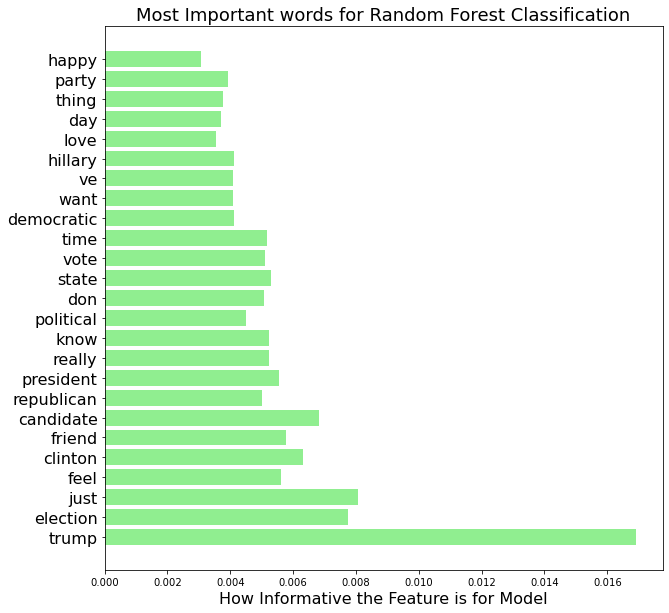

In [193]:
plt.figure(figsize=(10,10))
plt.barh(feature_df.index, feature_df['Importance'], color='lightgreen')
plt.title('Most Important words for Random Forest Classification', fontsize=18)
plt.xlabel('How Informative the Feature is for Model', fontsize=16)
plt.yticks(fontsize=16);

### Analysis
The Important words are a mixture of words important to classify political discussion and casual conversations. The Importance score tells us how informative each word is when classifying with a random forest. 

While there is a mixture of important words, the political discussion words are more well represented in most informative words. 


## Random Forest Model 2 - How Leaky is my Data?

In this next Random Forest model I am evaluating how leaky my model is due to the inclusion of the words "politics", "political", and "politic" in my dataset. My hypothesis is that removing these words from my wordban will make my model slightly less accurate because they are so indicative of being in the PoliticalDiscussions subreddit. However, I do not think removing these words will have a massive effect on the accuracy of my model due to the large signal generated by a slew of other words in PoliticalDiscussions.

In [89]:
df_2 = pd.read_csv('./Data/casual_political_2.csv')

X_2 = df_2['lemma_totaltext']
y_2 = df_2['binary_sub']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=16)

In [90]:
grid_2 = GridSearchCV(pipe, params, cv = 5,
                    scoring = 'accuracy', verbose = 1, n_jobs = -1)

grid_2.fit(X_2_train, y_2_train);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 15.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=16))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 50, 100],
                         'rf__max_features': ['auto', 'log2', 10, 50],
                         'rf__n_estimators': [75, 100, 175, 250]},
             scoring='accuracy', verbose=1)

In [91]:
grid_2.score(X_2_train, y_2_train)

1.0

In [92]:
grid_2.score(X_2_test, y_2_test)

0.9882851445663011

My hypothesis was correct! Removing those words did not have a significant impact on my testing score. Therefore, I will use my first Random Forest because it has a higher testing accuracy and is not leaking too much due to the inclusion of "politic", "politics", and "political".

In [158]:
#forest.fit(X, y)
importances_2 = grid_2.best_estimator_.named_steps['rf'].feature_importances_
std_2 = np.std([tree.feature_importances_ for tree in grid_2.best_estimator_.named_steps['rf']],
             axis=0)
indices_2 = np.argsort(std_2)[::-1]
vocab_2 = grid_2.best_estimator_.named_steps['tvec'].get_feature_names()

# Creating feature_df 
feature_df_2 = pd.DataFrame({'Top Words', 'Importance'}).set_index(0)

# Iterating over indices and creating DataFrame with 25 most important words
i = 0
while i < 25: 
    feature_df_2.loc[i, 'Top Words'] = vocab_2[indices_2[i]]
    feature_df_2.loc[i, 'Importance'] = importances_2[indices_2[i]]
    i+=1
    

In [159]:
feature_df_2 = feature_df_2.set_index('Top Words').dropna()
feature_df_2

,Importance
Top Words,
trump,0.015893
election,0.009292
feel,0.007409
just,0.007403
vote,0.006286
clinton,0.006814
president,0.005553
life,0.005313
campaign,0.005155


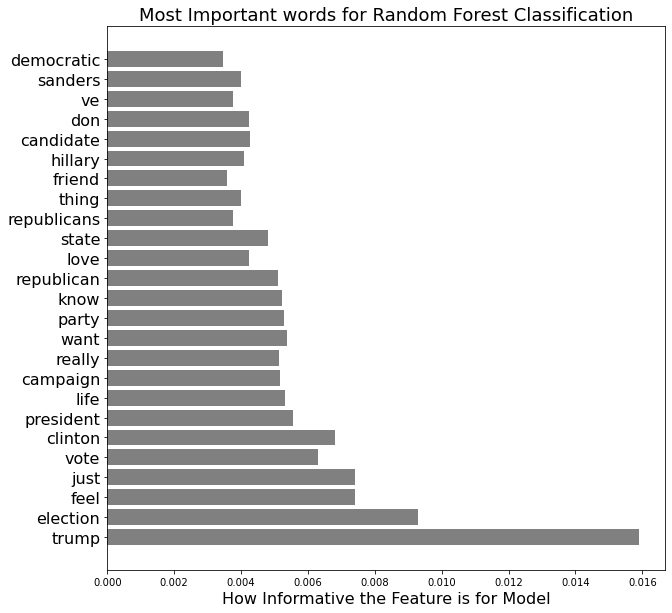

In [189]:
plt.figure(figsize=(10,10))
plt.barh(feature_df_2.index, feature_df_2['Importance'], color='grey')
plt.title('Most Important words for Random Forest Classification', fontsize=18)
plt.xlabel('How Informative the Feature is for Model', fontsize=16)
plt.yticks(fontsize=16);

#### Classification Metrics

In order to evaluate the model, I need to be able to evaluate how many posts were classified correctly, and how many posts were classified incorrectly. In order to do so, I can use classification metrics that illuminate how many outcomes were true positives (correctly predicted political text), false positives (incorrectly predicted political text), false negatives (icorrectly predicted casual text), and true negatives (correctly predicted casual text). 

In [175]:
# y predictions using grid search variable created earlier
y_hat = grid.predict(X_test)

<Figure size 720x720 with 0 Axes>

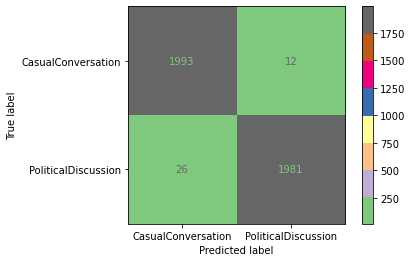

In [186]:
# Displaying actual confusion matrix 
plt.figure(figsize=(10,10))
metrics.plot_confusion_matrix(grid, X_test, y_test, cmap='Accent', 
                      values_format='d', display_labels=['CasualConversation', 
                                                         'PoliticalDiscussion']);
plt.savefig('../Figures/confusion_matrix.png')

My model predicted:

* 1993 True Positives (Correctly predicted r/PoliticalDiscussion)
* 1981 True Negatives (Correctly predicted r/CasualConversation)
* 26 False Negatives (Incorrectly predicted r/CasualConversation)
* 12 False Positives (Incorrectly predicted r/PoliticalDiscussion)

Overall, these are fantastic ratios and indicate that I am on the right path for differentiating between the casual and political discussions.

<Figure size 720x720 with 0 Axes>

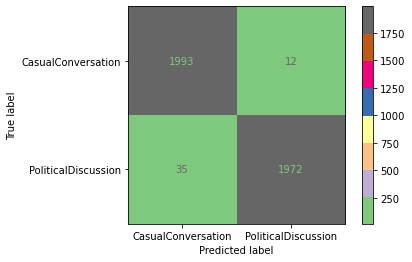

<Figure size 1008x1008 with 0 Axes>

In [188]:
# Removing "politic" words from dataframe
plt.figure(figsize=(10,10))
metrics.plot_confusion_matrix(grid_2, X_2_test, y_2_test, cmap='Accent', 
                      values_format='d', display_labels=['CasualConversation', 
                                                         'PoliticalDiscussion']);

This model is still fantastic for production use. It would be interesting to determine how the two differed on actual social media posts. 

<Figure size 720x720 with 0 Axes>

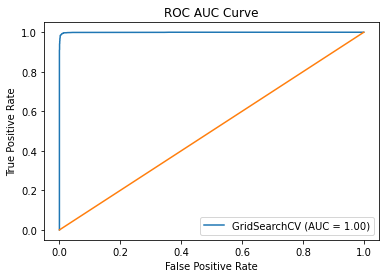

In [192]:
# ROC curve

metrics.plot_roc_curve(grid, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1])
plt.title('ROC AUC Curve');

#### Analysis
My ROC curve shows that the CasualConversation and PoliticalDiscussion classes are perfectly separated, indicating my model is as good as it can get. This was also seen by the high degree of separation in the log(odds) of the political and casual words. 

In [179]:
# ROC AUC score nearly 1
metrics.roc_auc_score(y_test, y_hat)

0.9905301519494736

In [180]:
accuracy = metrics.accuracy_score(y_test, y_hat)

#specificity = true negative/(true neagtive +false positive)
specificity = 1993/(1993+12) 

sensitivity =  metrics.recall_score(y_test, y_hat)

precision = metrics.precision_score(y_test, y_hat)

* Accuracy: What percentage of political and casual texts did I correctly predict? 
* Sensitivity: Among political texts, what percentage of texts did I correctly predict?
* Specificity: Among casual texts, what percentage of texts did I correctly predict? 
* Precision: Among those I predicted to be political texts, what percentage of texts did I correctly predict?

In [181]:
print('My accuracy is: ', round(accuracy,2))
print('My specificity is: ', round(specificity, 2))
print('My sensitivity is: ', round(sensitivity,2))
print('My precision is: ', round(precision,2))

My accuracy is:  0.99
My specificity is:  0.99
My sensitivity is:  0.99
My precision is:  0.99


In [182]:
# Creating classification report 
print(metrics.classification_report(y_test, y_hat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2005
           1       0.99      0.99      0.99      2007

    accuracy                           0.99      4012
   macro avg       0.99      0.99      0.99      4012
weighted avg       0.99      0.99      0.99      4012



Model Summary Table:

|Model| Train Accuracy| Test Accuracy| AUC ROC| True Positive| True Negative| False Positive| False Negative|
|---|---|---|---|---|---|---|---|
|Logistic Regression| 1.0|0.989|0.989|1983|1984|21|24|
|Random Forest|1.0|0.990|0.990|1993|1981|12|26|

### Conclusion

My random forest model performed even better than my logistic regression. YUltimately, I believe the random forest is the ideal model to productionize because of its low variance error, allowing it to scale better to text outside the traditional reddit submission structure. One downside to this model is the time that it takes to be fit, but once fit it can make predictions quickly on any text. 

# Please Continue to Notebook 3C